# LogBook

## Updates 10/04

Up to now we implemented Consiglio algorithm and tested It with statevector up to $N=5$, with QASM simulator and FakeManila up to $N = 3$.

Ansatz: TwoLocal (1 rep for ancilla, up to 2 for system)
Optimizer = COBYLA
Two strategies: A) High optimizer tolerance, high iterations OR Z) very low optimizer tolerance - low iterations with several random initial guesses. Not always finds convergence, with enough iterations It goes quite near though.
Anyway, good results for many cases.

Tasks are:
- Try initializing first guess for strategy A) with the previous point's optimized parameters, calling A1
- Implement PMA and study It
- Implement SPSA with lambda functions bc Qiskit doesn't allow to put args like scipy does

Our goal is to study the model with at least $N=4$ so that It actually differs from Ising.

### A0 vs A1 COBYLA comparison

Load data

In [ ]:
import pickle
import numpy as np


from qiskit.quantum_info import partial_trace, state_fidelity
from library import plotting, setup
from library.operator_creation import LMG_hamiltonian
from library.MHETS import MHETS_instance


flag = "statevector"
backend = None  # Only for graphic purposes

path = "./MHETS_data/Temp_Test_10_04/"
file_names = []
for N in [2]:
    for gy in [0.49]:
        for B in [0.2, 0.5]:
            H = LMG_hamiltonian(N, gy, B)
            file_names.append((setup.setup_file_name(H, flag, pma_flag=False)).replace(".pickle", "_reps2_A0.pickle"))
            file_names.append((setup.setup_file_name(H, flag, pma_flag=False)).replace(".pickle", "_reps2_A1.pickle"))
for N in [3]:
    for gy in [0.49]:
        for B in [0.2, 0.7]:
            H = LMG_hamiltonian(N, gy, B)
            file_names.append((setup.setup_file_name(H, flag, pma_flag=False)).replace(".pickle", "_reps3_A0.pickle"))
            file_names.append((setup.setup_file_name(H, flag, pma_flag=False)).replace(".pickle", "_reps3_A1.pickle"))

multi_data = setup.loading_offline_multi_data(path, file_names)

We want to compare n_eval and accuracy (in terms of fidelity and relative entropy). 
Collect these quantities

In [ ]:
n_eval = []
rel_entropy = []
fidelity = []


for data_index in range(len(multi_data)):
    beta_list = multi_data[data_index]["betas"]
    H = setup.name_to_H(file_names[data_index])
    rho_s_list = setup.data_to_rho_s(multi_data[data_index], H)

    temp_rel_entropy = []
    for index in range(len(beta_list)):
        temp_rel_entropy.append(
            H.relative_entropy(
                rho_s_list[index].to_operator().to_matrix(),
                H.get_thermal_state(beta_list[index]),
            )
        )
    temp_fidelity = []
    for index in range(len(beta_list)):
        temp_fidelity.append(
            state_fidelity(rho_s_list[index], H.get_thermal_state(beta_list[index]))
        )

    n_eval.append(np.mean(multi_data[data_index]["n_eval"]))
    rel_entropy.append(np.mean(temp_rel_entropy))
    fidelity.append(np.mean(temp_fidelity))

In [ ]:
import matplotlib.pyplot as plt


    
def A0vsA1(quantity, quantity_name):
    
    def full_list_to_split(quantity):
        _2at_A0 = []
        _2at_A1 = []
        _3at_A0 = []
        _3at_A1 = []

        for B_index in (0,2):
            _2at_A0.append(quantity[B_index])
            _2at_A1.append(quantity[B_index+1])
            _3at_A0.append(quantity[B_index+4])
            _3at_A1.append(quantity[B_index+5])

        return _2at_A0, _2at_A1, _3at_A0, _3at_A1

    plt.rcParams["figure.figsize"] = [7.50, 5.50]
    plt.rcParams["figure.autolayout"] = True
    
    plt.title("A0 vs A1 {} comparison - gy= 0.49".format(quantity_name))
    plt.xlabel("B")
    plt.ylabel("{}".format(quantity_name))
   
    
    _2at_A0, _2at_A1, _3at_A0, _3at_A1 = full_list_to_split(quantity)
    
    plt.scatter([0.2, 0.5],
                _2at_A0,
                color="blue",
               label="N=2 - A0")
    plt.scatter([0.2, 0.5],
                _2at_A1,
                color="cyan",
               label="N=2 - A1")
    plt.scatter([0.2, 0.7],
                _3at_A0,
                color="red",
               label="N=3 - A0")
    plt.scatter([0.2, 0.7],
                _3at_A1,
                color="magenta",
               label="N=3 - A1") 
    
    plt.legend()
    plt.grid()
    plt.show()

Plot them

In [ ]:
A0vsA1(n_eval, "Average n_eval")
A0vsA1(fidelity, "Average fidelity")
A0vsA1(rel_entropy, "Average rel_entropy")

Initializing a first guess makes convergence faster of almost a factor 2 for $N=2$ and about 1.5 for $N=3$ without losing accuracy.

### TwoLocal vs PMA Comparison

Load data

In [ ]:
import pickle
import numpy as np


from qiskit.quantum_info import partial_trace, state_fidelity
from library import plotting, setup
from library.operator_creation import LMG_hamiltonian
from library.MHETS import MHETS_instance


flag = "statevector"
backend = None  # Only for graphic purposes

path = "./MHETS_data/Temp_Test_10_04/"
file_names = []
for N in [2]:
    for gy in [0.49]:
        for B in [0.2, 0.5]:
            H = LMG_hamiltonian(N, gy, B)
            file_names.append((setup.setup_file_name(H, flag, pma_flag=False)).replace(".pickle", "_reps2_A1.pickle"))
            file_names.append((setup.setup_file_name(H, flag, pma_flag=True)).replace(".pickle", "_reps1_A1.pickle"))
for N in [3]:
    for gy in [0.49]:
        for B in [0.2, 0.7]:
            H = LMG_hamiltonian(N, gy, B)
            file_names.append((setup.setup_file_name(H, flag, pma_flag=False)).replace(".pickle", "_reps3_A1.pickle"))
            file_names.append((setup.setup_file_name(H, flag, pma_flag=True)).replace(".pickle", "_reps1_A1.pickle"))

for N in [4]:
    for gy in [0.49]:
        for B in [0.075, 0.35, 0.7]:
            H = LMG_hamiltonian(N, gy, B)
            file_names.append((setup.setup_file_name(H, flag, pma_flag=False)).replace(".pickle", "_reps4_A1.pickle"))
            file_names.append((setup.setup_file_name(H, flag, pma_flag=True)).replace(".pickle", "_reps2_A1.pickle"))

            
multi_data = setup.loading_offline_multi_data(path, file_names)

Collect the quantities from data

In [ ]:
n_eval = []
rel_entropy = []
fidelity = []


for data_index in range(len(multi_data)):
    beta_list = multi_data[data_index]["betas"]
    H = setup.name_to_H(file_names[data_index])
    rho_s_list = setup.data_to_rho_s(multi_data[data_index], H)

    temp_rel_entropy = []
    for index in range(len(beta_list)):
        temp_rel_entropy.append(
            H.relative_entropy(
                rho_s_list[index].to_operator().to_matrix(),
                H.get_thermal_state(beta_list[index]),
            )
        )
    temp_fidelity = []
    for index in range(len(beta_list)):
        temp_fidelity.append(
            state_fidelity(rho_s_list[index], H.get_thermal_state(beta_list[index]))
        )

    n_eval.append(np.mean(multi_data[data_index]["n_eval"]))
    rel_entropy.append(np.mean(temp_rel_entropy))
    fidelity.append(np.mean(temp_fidelity))

In [ ]:
import matplotlib.pyplot as plt




def TwoLocalvsPMA(quantity, quantity_name):
    
    def full_list_to_split(quantity):
        _2at_TL = []
        _2at_PMA = []
        _3at_TL = []
        _3at_PMA = []
        _4at_TL = []
        _4at_PMA = []

        for B_index in (0,2):
            _2at_TL.append(quantity[B_index])
            _2at_PMA.append(quantity[B_index+1])
            _3at_TL.append(quantity[B_index+4])
            _3at_PMA.append(quantity[B_index+5])
            _4at_TL.append(quantity[B_index+8])
            _4at_PMA.append(quantity[B_index+9])
            
        #N=4 has three phases so 3 B points taken
        _4at_TL.append(quantity[12])
        _4at_PMA.append(quantity[13])
            
        return _2at_TL, _2at_PMA, _3at_TL, _3at_PMA, _4at_TL, _4at_PMA

    plt.rcParams["figure.figsize"] = [7.50, 5.50]
    plt.rcParams["figure.autolayout"] = True
    
    plt.title("TwoLocal vs PMA {} comparison - gy= 0.49".format(quantity_name))
    plt.xlabel("B")
    plt.ylabel("{}".format(quantity_name))
   
    
    _2at_TL, _2at_PMA, _3at_TL, _3at_PMA, _4at_TL, _4at_PMA = full_list_to_split(quantity)
    
    plt.scatter([0.2, 0.5],
                _2at_TL,
                color="blue",
                label="N=2 - TwoLocal_reps2 - A1")
    plt.scatter([0.2, 0.5],
                _2at_PMA,
                color="cyan",
                label="N=2 - PMA_reps1 - A1")
    plt.scatter([0.2, 0.7],
                _3at_TL,
                color="red",
                label="N=3 - TwoLocal_reps3 - A1")
    plt.scatter([0.2, 0.7],
                _3at_PMA,
                color="magenta",
                label="N=3 - PMA_reps1 - A1") 
    plt.scatter([0.075, 0.35, 0.7],
                _4at_TL,
                color="black",
                label="N=4 - TwoLocal_reps4 - A1")
    plt.scatter([0.075, 0.35, 0.7],
                _4at_PMA,
                color="lightgrey",
                label="N=4 - PMA_reps2 - A1") 

    
    
    plt.legend()
    plt.grid()
    plt.show()

Plot them

In [ ]:
TwoLocalvsPMA(n_eval, "Average n_eval")
TwoLocalvsPMA(fidelity, "Average Fidelity")
TwoLocalvsPMA(rel_entropy, "Average rel_entropy")

PMA seems to be more efficient for $N=2$ but point-depending for $N=3$. We can say that It's more robust because with very few iterations It comes quite near the 90% fidelity threshold.
Also for $N=4$ we can see that It's way more accurate, expecially for ordered phases.

Some info that can be useful If I forgot something along the way:
- N=2 -> PMA with Reps1
- N=2 -> TL with Reps2 otherwise with A0 fidelity about 90% which is not ok for N=2
- N=3 -> PMA with Reps 1 (Reps 2 no tried but fid above 95%)
- N=3 -> TL with Reps3 unless with A0 It's fine fidelity about 93%
- N=4 -> Found decent results with PMA-A1 architecture full maxiter 900
- N=4 -> PMA slightly better results for system ansatz 2 reps linear and ancilla ansatz 1 rep full but no convergence 

In [ ]:
#print(multi_data[0]["optimization_options"])

### Final Choice (PMA A1)

Load data

In [68]:
import pickle
import numpy as np


from qiskit.quantum_info import partial_trace
from library import plotting, setup
from library.operator_creation import LMG_hamiltonian
from library.MHETS import MHETS_instance



flag = "noise"
backend = None  # Only for graphic purpose
N = 2
gy = 0.49
B = 0.56
H = LMG_hamiltonian(N, gy, B)

path = "./MHETS_data/Temp_Test_17_04/"
file_name = setup.setup_file_name(H, flag, shots=100, pma_flag=True)
file_name = file_name.replace(".pickle", "_spsa_Z.pickle")
with open(path + file_name, "rb") as f:
    multi_beta_result = pickle.load(f)
optimization_options = multi_beta_result["optimization_options"]
beta_list = multi_beta_result["betas"]

Building operators

In [69]:
rho_s_list = setup.data_to_rho_s(multi_beta_result, H)

Plots to see convergence

C:\Users\39339\anaconda3\envs\MyQiskitEnv\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\39339\anaconda3\envs\MyQiskitEnv\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


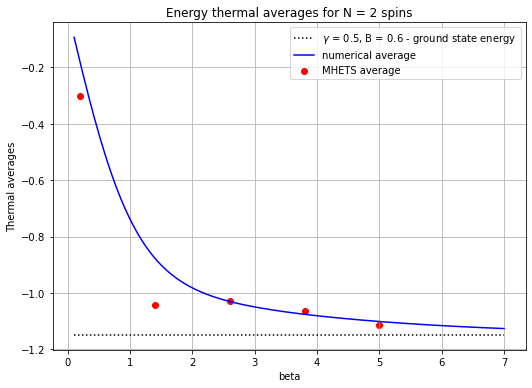

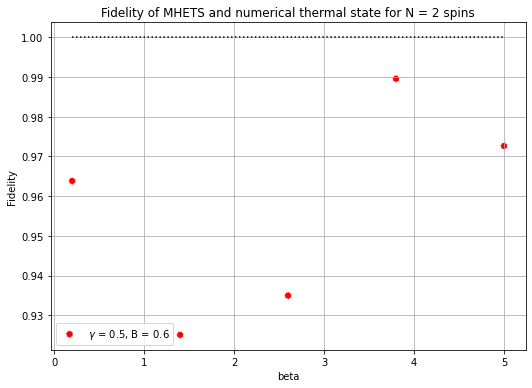

C:\Users\39339\anaconda3\envs\MyQiskitEnv\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


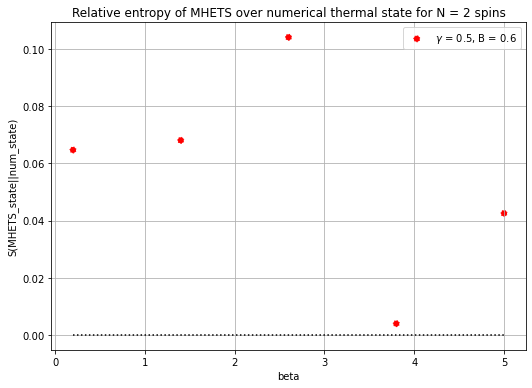

C:\Users\39339\anaconda3\envs\MyQiskitEnv\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\39339\anaconda3\envs\MyQiskitEnv\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


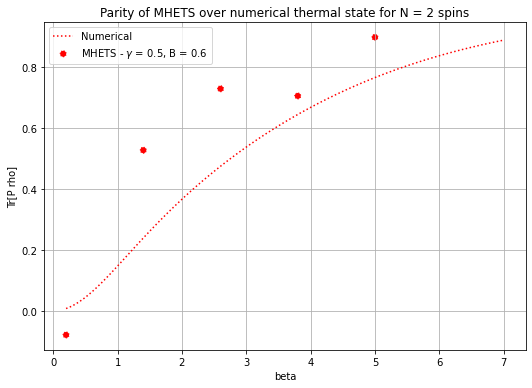

In [70]:
plotting.plot_MHETS_thermal_average(
    beta_list, rho_s_list, H, backend=backend, beta_final = 7
)
plotting.plot_fidelity(beta_list, rho_s_list, H, backend=backend)
plotting.plot_rel_entropy(beta_list, rho_s_list, H, backend=backend)
plotting.plot_parity(beta_list, rho_s_list, H, backend=backend)

In [67]:
print(multi_beta_result["optimization_options"])
print("")
print(multi_beta_result["n_eval"])
print(multi_beta_result["optimization_options"]["system_num_reps"])
print(multi_beta_result["optimization_options"]["tol"])

{'ancilla_ansatz': 'two_local', 'ancilla_num_reps': 1, 'ancilla_ansatz_entanglement': 'linear', 'ancilla_ansatz_rotation_blocks': ['ry'], 'ancilla_ansatz_entanglement_blocks': ['cx'], 'system_ansatz': 'pma', 'system_num_reps': 0, 'system_ansatz_architecture': 'linear', 'maxiter': 50, 'optimizer': 'cobyla', 'initial_parameter_list': [None, None, None, None, None], 'flag': 'noise', 'tol': 1e-06, 'shots': 100}

[50, 50, 50, 50, 50]
0
1e-06


## Updates 17/04

### COBYLA vs SPSA

Now we can start testing differences between the optimizers. We focus also on studying reliability of strategy A1 vs Z since with noise It's easier to fall in local minima, and Z strategy takes several runs from random initial guesses.

About statevector tests we already know SPSA would not be better than COBYLA (at least speaking from VQE experience) but using a noise model, If It'll actually need less iterations, we'll be able to work on $N=4$.
!!! 1 iteration needs about 1000s to run. !!!

#### Statevector test

Load data

In [71]:
import pickle
import numpy as np


from qiskit.quantum_info import partial_trace, state_fidelity
from library import plotting, setup
from library.operator_creation import LMG_hamiltonian
from library.MHETS import MHETS_instance


flag = "noise"
backend = "FakeManila"  # Only for graphic purposes

path = "./MHETS_data/Temp_Test_17_04/"
file_names = []
for N in [2]:
    for gy in [0.49]:
        for B in [0.14, 0.56]:
            H = LMG_hamiltonian(N, gy, B)
            file_names.append((setup.setup_file_name(H, flag, shots=100, pma_flag=True)).replace(".pickle", "_cobyla.pickle"))
            file_names.append((setup.setup_file_name(H, flag, shots=100, pma_flag=True)).replace(".pickle", "_spsa.pickle"))
for N in [2]:
    for gy in [0.49]:
        for B in [0.14, 0.56]:
            H = LMG_hamiltonian(N, gy, B)
            file_names.append((setup.setup_file_name(H, flag, shots=100, pma_flag=True)).replace(".pickle", "_cobyla_Z.pickle"))
            file_names.append((setup.setup_file_name(H, flag, shots=100, pma_flag=True)).replace(".pickle", "_spsa_Z.pickle"))

multi_data = setup.loading_offline_multi_data(path, file_names)

We want to compare n_eval and accuracy (in terms of fidelity and relative entropy). 
Collect these quantities

In [72]:
n_eval = []
rel_entropy = []
fidelity = []


for data_index in range(len(multi_data)):
    beta_list = multi_data[data_index]["betas"]
    H = setup.name_to_H(file_names[data_index])
    rho_s_list = setup.data_to_rho_s(multi_data[data_index], H)

    temp_rel_entropy = []
    for index in range(len(beta_list)):
        temp_rel_entropy.append(
            H.relative_entropy(
                rho_s_list[index].to_operator().to_matrix(),
                H.get_thermal_state(beta_list[index]),
            )
        )
    temp_fidelity = []
    for index in range(len(beta_list)):
        temp_fidelity.append(
            state_fidelity(rho_s_list[index], H.get_thermal_state(beta_list[index]))
        )

    n_eval.append(np.mean(multi_data[data_index]["n_eval"]))
    rel_entropy.append(np.mean(temp_rel_entropy))
    fidelity.append(np.mean(temp_fidelity))

In [73]:
import matplotlib.pyplot as plt


    
def COBYLAvsSPSA(quantity, quantity_name):
    
    def full_list_to_split(quantity):
        _2at_coby = []
        _2at_spsa = []
        _2at_coby_Z = []
        _2at_spsa_Z = []
    
        for B_index in [0, 2]:
            _2at_coby.append(quantity[B_index])
            _2at_spsa.append(quantity[B_index+1])
            _2at_coby_Z.append(quantity[B_index+4])
            _2at_spsa_Z.append(quantity[B_index+5])


        return _2at_coby, _2at_spsa, _2at_coby_Z, _2at_spsa_Z

    plt.rcParams["figure.figsize"] = [7.50, 5.50]
    plt.rcParams["figure.autolayout"] = True
    
    plt.title("COBYLA vs SPSA {} comparison - gy= 0.49".format(quantity_name))
    plt.xlabel("B")
    plt.ylabel("{}".format(quantity_name))
   
    
    _2at_coby, _2at_spsa, _2at_coby_Z, _2at_spsa_Z = full_list_to_split(quantity)
    
    plt.scatter([0.14, 0.56],
                _2at_coby,
                color="blue",
               label="N=2 - COBYLA - A1")
    plt.scatter([0.14, 0.56],
                _2at_spsa,
                color="cyan",
               label="N=2 - SPSA - A1")
    plt.scatter([0.14, 0.56],
                _2at_coby_Z,
                color="red",
               label="N=2 - COBYLA - Z")
    plt.scatter([0.14, 0.56],
                _2at_spsa_Z,
                color="magenta",
               label="N=2 - SPSA - Z") 
    
    plt.legend()
    plt.grid()
    plt.show()

Plot them.

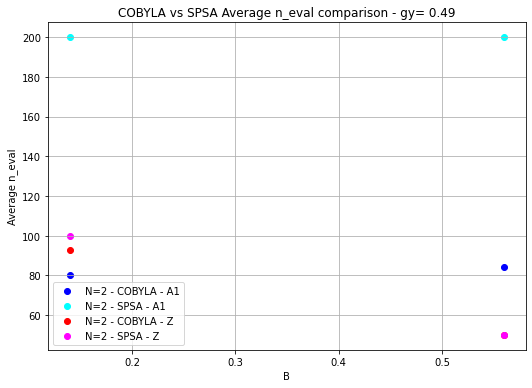

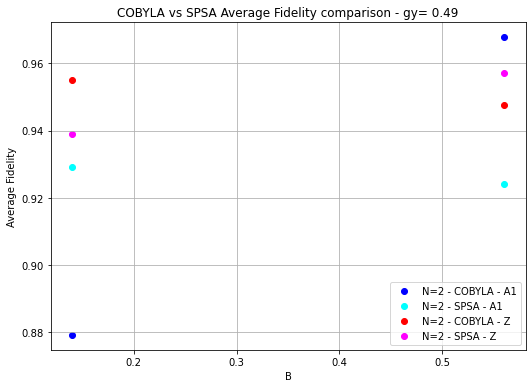

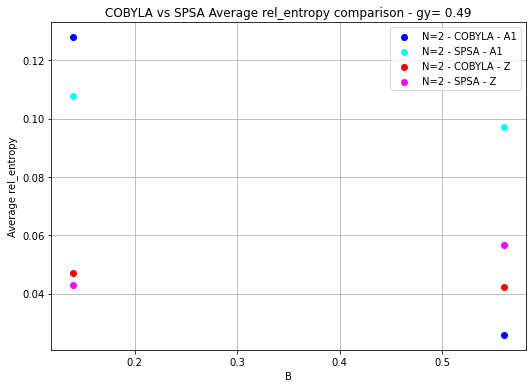

In [74]:
COBYLAvsSPSA(n_eval, "Average n_eval")
COBYLAvsSPSA(fidelity, "Average Fidelity")
COBYLAvsSPSA(rel_entropy, "Average rel_entropy")

COBYLA takes about 90 iterations to converge when in noisy environment. SPSA doesn't converge (no many tries because of time) and I can't actually see the advantage in Its use since It also has a calibration step. Maybe we have to see worst results: for example at B=0.56 even tho average fidelity is similar, SPSA worst fidelity is about 0.93, COBYLA is about 0.88

- SPSA A1 -> Gave It 100 maxiter (total 250 iterations because SPSA uses 2 iterations to estimate gradient + 50 for calibration)
- SPSA Z for B=0.56 -> Gave It 25 maxiter (total 150 iterations)
- COBYLA Z for B=0.56 -> Gave It 50 maxiter

We can also have a look at how the optimizers come to the solution:

N.B. During simulation (which lasted a few days) I changed the way to collect callback data because I think my RAM can't take that much data (It was at 99% and PC lagged hard but I don't actually know If the problem was that). I'm writing this because you can use the cell below for N=2, B=0.14, 0.56 except COBYLA_Z at B=0.56

In [86]:
import pickle
import numpy as np


from qiskit.quantum_info import partial_trace, state_fidelity
from library import plotting, setup
from library.operator_creation import LMG_hamiltonian
from library.MHETS import MHETS_instance



flag = "noise"
backend = "FakeManila"  # Only for graphic purposes

path = "./MHETS_data/Temp_Test_17_04/"
file_names = []
for N in [2]:
    for gy in [0.49]:
        for B in [0.14]:
            H = LMG_hamiltonian(N, gy, B)
            file_names.append((setup.setup_file_name(H, flag, shots=100, pma_flag=True)).replace(".pickle", "_cobyla.pickle"))
            file_names.append((setup.setup_file_name(H, flag, shots=100, pma_flag=True)).replace(".pickle", "_spsa.pickle"))

            
multi_data = setup.loading_offline_multi_data(path, file_names)

In [94]:
import matplotlib.pyplot as plt



def plot_MHETS_shots(multi_data, betas, H):
    def take_helm_energy(multi_beta_result, beta, H):
        helm_energy_list = []

        beta_index = multi_beta_result["betas"].index(beta)
        for data in multi_beta_result["callback_data"][beta_index]:
            rho = data.analysis_results("state").value
            prob_ancilla = rho.probabilities(range(0, H.N))

            entropy = 0.0
            for index in range(len(prob_ancilla)):
                if prob_ancilla[index] != 0.0:
                    entropy -= prob_ancilla[index] * np.log(prob_ancilla[index])
            rho_S = partial_trace(rho, range(H.N))

            system_exp_value = np.trace(rho_S @ H.get_matrix())

            helm_energy_list.append(np.real(system_exp_value - (1.0 / beta) * entropy))
        return helm_energy_list

    color_list = ["blue", "red", "green", "gold", "orange"]

    fig, axs = plt.subplots(len(betas), sharex=True)
    plt.rcParams["figure.figsize"] = [7.50, 5.50]
    plt.rcParams["figure.autolayout"] = True

    gylabel = "{} with n_shots = {}"

    fig.suptitle(
        "Helmoltz energy optimization for N = {N:.0f}, $\gamma$ = {gy:.1f}, B = {B:.1f}".format(
            N=H.N, gy=H.gy, B=H.B
        )
    )

    for beta in betas:
        maxiter_list = range(1, multi_data[0]["optimization_options"]["maxiter"] + 1)
        axs[np.where(betas == beta)[0][0]].plot(
            maxiter_list,
            [H.cost_function(beta) / beta for _ in range(len(maxiter_list))],
            color="black",
            ls="dotted",
            label="Numerical value for beta = {}".format(beta),
        )

        for index in range(len(multi_data)):
            beta_index = multi_data[index]["betas"].index(beta)
            n_iterations = multi_data[index]["n_eval"][beta_index] + 1
            if multi_data[index]["optimization_options"]["optimizer"] in (
                "spsa",
                "SPSA",
            ):
                n_iterations += 51
            
            
            # IF YOU WANT TO LOOK ALSO AT THE CALIBRATION STEPS JUST RUN THE CODE IN THE "ELSE"
            if multi_data[index]["optimization_options"]["optimizer"] in (
                "spsa",
                "SPSA",
            ):
                axs[np.where(betas == beta)[0][0]].plot(
                    range(1, n_iterations-51),
                    take_helm_energy(multi_data[index], beta, H)[51:],
                    color=color_list[index],
                    label="{} with n_ shots = {}".format(multi_data[index]["optimization_options"]["optimizer"], 
                                                         multi_data[index]["optimization_options"]["shots"]
                    ),
                )
            else:
                axs[np.where(betas == beta)[0][0]].plot(
                    range(1, n_iterations),
                    take_helm_energy(multi_data[index], beta, H),
                    color=color_list[index],
                    label="{} with n_ shots = {}".format(multi_data[index]["optimization_options"]["optimizer"], 
                                                         multi_data[index]["optimization_options"]["shots"]
                    ),
                )
                
                
    for ax in axs.flat:
        ax.set(xlabel="N evaluation", ylabel="Helmoltz energy")
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        ax.legend()  # Show legend
        

        
def plot_MHETS_shots_fidelity(multi_data, betas, H):
    
    def take_QST_fidelity(multi_beta_result, beta, H):
        QST_fidelity_list = []

        beta_index = multi_beta_result["betas"].index(beta)
        for data in multi_beta_result["callback_data"][beta_index]:
            QST_fidelity_list.append(data.analysis_results("state_fidelity").value)
        return QST_fidelity_list


    color_list = ["blue", "red", "green", "gold", "orange"]

    fig, axs = plt.subplots(len(betas), sharex=True)
    plt.rcParams["figure.figsize"] = [7.50, 5.50]
    plt.rcParams["figure.autolayout"] = True


    fig.suptitle(
        "QST fidelity during optimization for N = {N:.0f}, $\gamma$ = {gy:.1f}, B = {B:.1f}".format(
            N=H.N, gy=H.gy, B=H.B
        )
    )

    for beta in betas:
        maxiter_list = range(1, multi_data[0]["optimization_options"]["maxiter"] + 1)
        axs[np.where(betas == beta)[0][0]].plot(
            maxiter_list,
            [1.0 for _ in range(len(maxiter_list))],
            color="black",
            ls="dotted",
            label="Max value - beta = {}".format(beta),
        )
        for index in range(len(multi_data)):
            beta_index = multi_data[index]["betas"].index(beta)
            n_iterations = multi_data[index]["n_eval"][beta_index] + 1
            if multi_data[index]["optimization_options"]["optimizer"] in (
                "spsa",
                "SPSA",
            ):
                n_iterations += 51
            
            
            # IF YOU WANT TO LOOK ALSO AT THE CALIBRATION STEPS JUST RUN THE CODE IN THE "ELSE"
            if multi_data[index]["optimization_options"]["optimizer"] in (
                "spsa",
                "SPSA",
            ):
                axs[np.where(betas == beta)[0][0]].plot(
                    range(1, n_iterations-51),
                    take_QST_fidelity(multi_data[index], beta, H)[51:],
                    color=color_list[index],
                    label="{} with n_ shots = {}".format(multi_data[index]["optimization_options"]["optimizer"], 
                                                         multi_data[index]["optimization_options"]["shots"]
                    ),
                )
            else:
                axs[np.where(betas == beta)[0][0]].plot(
                    range(1, n_iterations),
                    take_QST_fidelity(multi_data[index], beta, H),
                    color=color_list[index],
                    label="{} with n_ shots = {}".format(multi_data[index]["optimization_options"]["optimizer"], 
                                                         multi_data[index]["optimization_options"]["shots"]
                    ),
                )

    for ax in axs.flat:
        ax.set(xlabel="N evaluation", ylabel="QST Fidelity")
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        ax.legend()  # Show legend

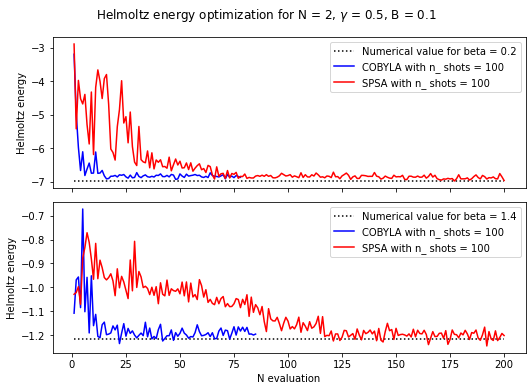

In [99]:
plot_MHETS_shots(multi_data=multi_data, betas=np.linspace(0.2, 1.4, 2), H=H)

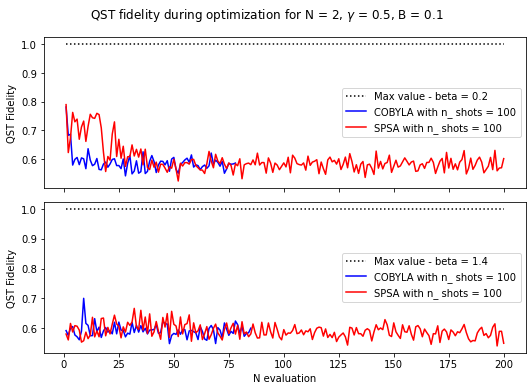

In [98]:
plot_MHETS_shots_fidelity(multi_data=multi_data, betas=np.linspace(0.2, 1.4, 2), H=H)

This is the cell to use If you want to look at COBYLA_Z N=2, B=0.56

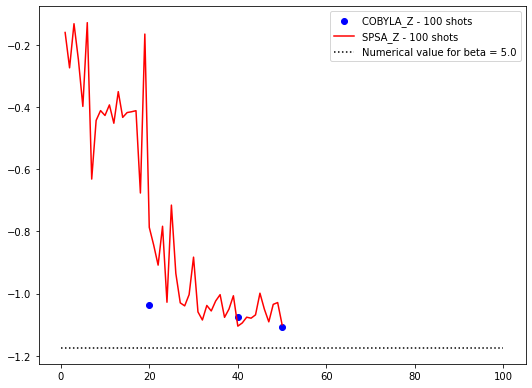

In [66]:
# Spartan plot implementation
def take_helm_energy(multi_beta_result, beta, H):
    helm_energy_list = []

    beta_index = multi_beta_result["betas"].index(beta)
    for data in multi_beta_result["callback_data"][beta_index]:
        rho = data.analysis_results("state").value
        prob_ancilla = rho.probabilities(range(0, H.N))

        entropy = 0.0
        for index in range(len(prob_ancilla)):
            if prob_ancilla[index] != 0.0:
                entropy -= prob_ancilla[index] * np.log(prob_ancilla[index])
        rho_S = partial_trace(rho, range(H.N))

        system_exp_value = np.trace(rho_S @ H.get_matrix())

        helm_energy_list.append(np.real(system_exp_value - (1.0 / beta) * entropy))
    return helm_energy_list

multi_data[0]
x_coby = [20, 40, 50]
beta = 5.
beta_index = multi_data[0]["betas"].index(beta)
y_coby = take_helm_energy(multi_data[0], beta, H)
y_coby.append(multi_data[0]["Helmoltz energy"][beta_index] / beta)
plt.scatter(x_coby, y_coby, color="blue", label="COBYLA_Z - 100 shots")

x_spsa = range(1, multi_data[1]["n_eval"][beta_index] + 1)
y_spsa = take_helm_energy(multi_data[1], beta, H)
plt.plot(x_spsa, y_spsa[51:], color="red", label="SPSA_Z - 100 shots")

plt.plot(
    range(0, 101),
    [H.cost_function(beta) / beta for _ in range(0, 101)],
    color="black",
    ls="dotted",
    label="Numerical value for beta = {}".format(beta),
)


plt.legend()
plt.show()